# Tracer selection using composite mixtures

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## % classified function

In [ ]:
classify <- function(data, model, by = "site", type = "percent") {
  if(type == "count") x <- table(as.data.frame(data)[,"site"], model$class)
  if(type == "percent") x <- diag(prop.table(table(as.data.frame(data)[,"site"], model$class), 1)) * 100
  x
}

## Load in data

In [ ]:
geo_results <- read.csv(here::here("./notebooks/Geochemistry analysis - Copy 2.csv")) %>%
  pivot_longer(cols = Ag:Zr, names_to = "Fingerprint", values_to = "value") %>%
  filter(Fingerprint %in% c("Ag", "Al", "As","B","Ba","Be","Bi","Ca","Cd","Ce","Co", "Cr", "Cs", "Cu", "Fe", "Ga", "Hf", "Hg", "In", "K", "La", "Li", "Mg", "Mn", "Mo", "Nb", "Ni", "P", "Pb", "Rb", "S", "Sb", "Sc", "Se", "Sn", "Sr", "Te", "Th", "Tl", "U", "V", "Y", "Zn", "Zr")) %>% # excludes fingerprints that are below level of detection
  dplyr::select(-X) %>% # don't need this column
  filter(sample_design %in% c("Grid", "Transect", "Likely to erode")) 

col_results <- read.csv(here::here("./notebooks/final results revised.csv")) %>%
  pivot_longer(cols = X:B, names_to = "Fingerprint", values_to = "value") %>%
  dplyr::select(-X.1) %>% # don't need this column
  filter(sample_design %in% c("Grid", "Transect", "Likely to erode")) %>%
  mutate(Fingerprint = paste0(Fingerprint, "_col")) # appended _col as some of the colour coefficients have the same id eg Boron = B and Blue also = B


# Bind data sets
results <- geo_results %>%
  bind_rows(col_results) 

## Virtual mixtures

In [ ]:
proportions <- seq(0, 1, 0.05)

mixtures <- results %>%
  filter(sample_design %in% c("Grid", "Likely to erode")) %>% # excluded transects as the transects are contained with in the grid this gives us all unique samples 
  group_by(Fingerprint, site) %>%
  summarise(avg =  mean(value)) %>%
  pivot_wider(names_from = site, values_from = avg) %>%
  mutate(mix_ag = map(Agriculture, ~.x * (1 - proportions)),
         mix_forest = map(Forest, ~.x * proportions)) %>%
  group_by(Fingerprint, Agriculture, Forest) %>%
  summarize(mix = map2(mix_ag, mix_forest, ~data.frame(mix = .x + .y, prop_forest = proportions))) %>%
  unnest(mix) %>%
  pivot_wider(id_cols = c("Fingerprint", "Agriculture", "Forest"), names_from = prop_forest, values_from = mix) 

`summarise()` has grouped output by 'Fingerprint'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Fingerprint', 'Agriculture'. You can
override using the `.groups` argument.

## Range test

`summarise()` has grouped output by 'site', 'sample_design'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Fingerprint'. You can override using the
`.groups` argument.
Joining with `by = join_by(Fingerprint)`

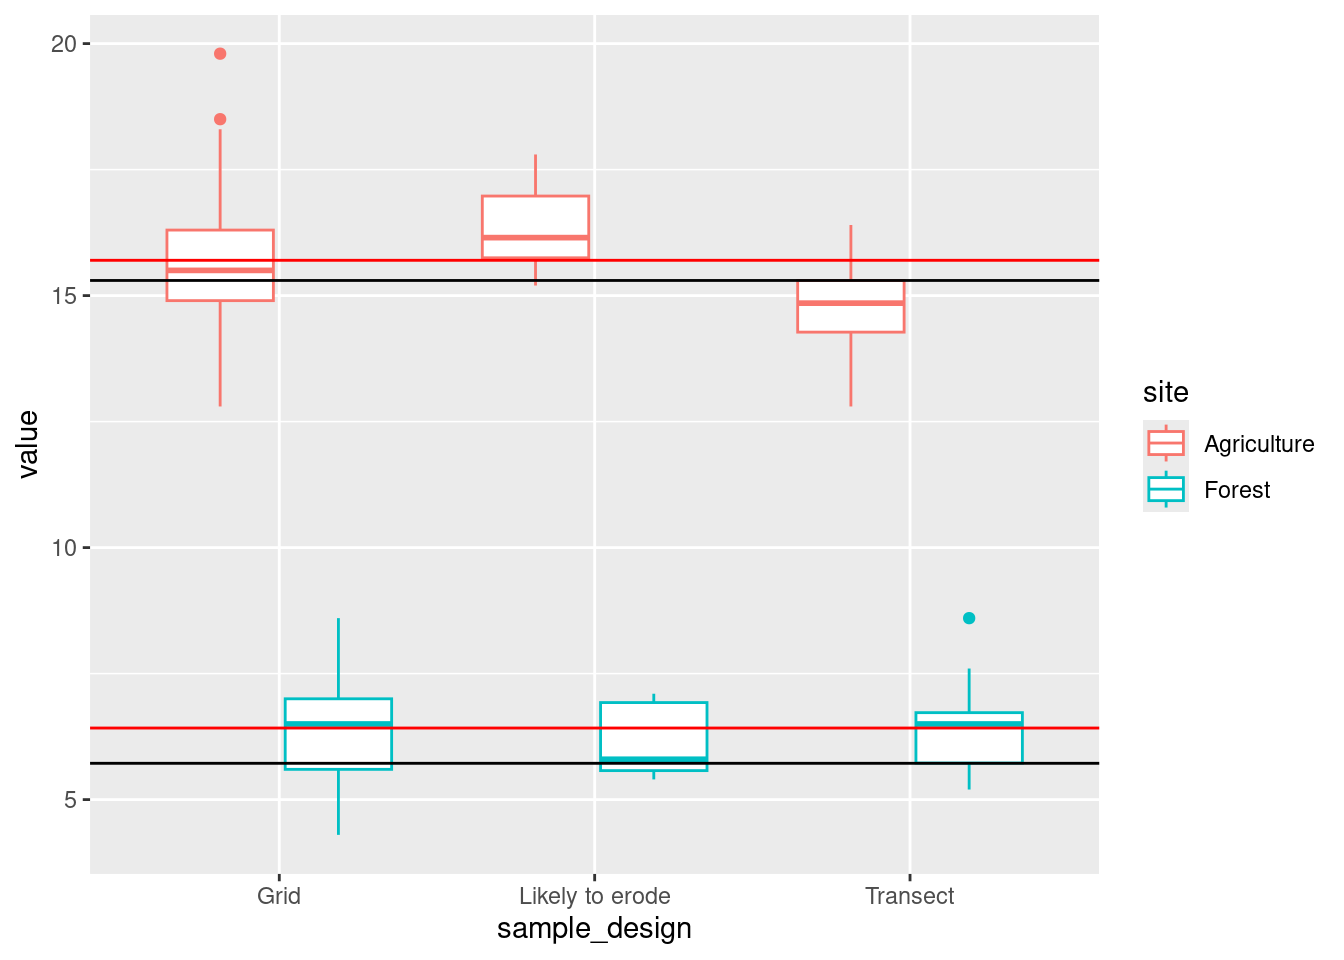

# A tibble: 3 × 2
  sample_design       n
  <chr>           <int>
1 Grid               58
2 Likely to erode    12
3 Transect           50

In [ ]:
range <- results %>%
  group_by(site, sample_design, Fingerprint) %>%
  summarise(upper_lim = quantile(value, 0.75),
            lower_lim = quantile(value, 0.25)) %>%
  group_by(Fingerprint, sample_design) %>%
  summarise(lower_lim = min(lower_lim),
            upper_lim = max(upper_lim)) %>%
  ungroup() %>%
  left_join(mixtures) %>%
  #dplyr::select(-c(Agriculture, Forest)) %>%
  group_by(Fingerprint, sample_design) %>%
  mutate(pass = all(round(`0`:`1`, 5) >= round(lower_lim, 5)) & all(round(`0`:`1`, 5) <= round(upper_lim, 5)))  ## rounding as differences as small as 10^-18 were being removed otherwise

## Mann-W test

In [ ]:
wilcox_test <- range_results %>%
  inner_join(results) %>%
  nest(data = c(-sample_design, -Fingerprint)) %>%
  mutate(test = map(data, ~wilcox.test(value ~ site, data = ., exact = FALSE))) %>%
  mutate(p_value = map_dbl(test, ~ .$p.value),
         statistic =  map_dbl(test, ~ .$statistic))

Joining with `by = join_by(Fingerprint, sample_design)`

# A tibble: 49 × 6
# Groups:   Fingerprint, sample_design [49]
   Fingerprint sample_design data              test     p_value statistic
   <chr>       <chr>         <list>            <list>     <dbl>     <dbl>
 1 Ag          Grid          <tibble [98 × 3]> <htest> 8.43e-15     2282.
 2 Al          Grid          <tibble [98 × 3]> <htest> 1.48e-17     2401 
 3 As          Grid          <tibble [98 × 3]> <htest> 8.37e-17     2372.
 4 B_col       Grid          <tibble [98 × 3]> <htest> 4.72e-11     2127 
 5 Be          Grid          <tibble [98 × 3]> <htest> 1.47e-17     2401 
 6 Bi          Grid          <tibble [98 × 3]> <htest> 2.85e-16     2349 
 7 Ca          Grid          <tibble [98 × 3]> <htest> 8.60e- 8     1954.
 8 Cd          Grid          <tibble [98 × 3]> <htest> 1.54e- 7     1939 
 9 Ce          Grid          <tibble [98 × 3]> <htest> 1.28e- 8     2002.
10 Co          Grid          <tibble [98 × 3]> <htest> 3.35e-11     2134.
# ℹ 39 more rows

 [1] "Ag"    "Al"    "As"    "B_col" "Be"    "Bi"    "Ca"    "Cd"    "Ce"   
[10] "Co"    "Cr"    "Cs"    "Cu"    "Fe"    "G_col" "Ga"    "Hf"    "Hg"   
[19] "In"    "K"     "L_col" "La"    "Li"    "Mg"    "Nb"    "Ni"    "Rb"   
[28] "S"     "Sb"    "Sc"    "Se"    "Sn"    "Sr"    "Te"    "Th"    "U"    
[37] "V"     "X_col" "Y"     "Y_col" "Z_col" "Zr"    "a_col" "b_col" "c_col"
[46] "h_col" "u_col" "v_col" "x_col"

# A tibble: 33 × 6
# Groups:   Fingerprint, sample_design [33]
   Fingerprint sample_design data              test       p_value statistic
   <chr>       <chr>         <list>            <list>       <dbl>     <dbl>
 1 Ag          Transect      <tibble [28 × 3]> <htest> 0.000319        176 
 2 Al          Transect      <tibble [28 × 3]> <htest> 0.00000734      196 
 3 As          Transect      <tibble [28 × 3]> <htest> 0.00000920      195 
 4 B_col       Transect      <tibble [28 × 3]> <htest> 0.00102         170 
 5 Be          Transect      <tibble [28 × 3]> <htest> 0.00000734      196 
 6 Ca          Transect      <tibble [28 × 3]> <htest> 0.000310        177 
 7 Cd          Transect      <tibble [28 × 3]> <htest> 0.00930         155 
 8 Ce          Transect      <tibble [28 × 3]> <htest> 0.00152         168.
 9 Co          Transect      <tibble [28 × 3]> <htest> 0.000433        175 
10 Cr          Transect      <tibble [28 × 3]> <htest> 0.00000703      196.
# ℹ 23 more rows

 [1] "Ag"    "Al"    "As"    "B_col" "Be"    "Ca"    "Cd"    "Ce"    "Co"   
[10] "Cr"    "Cs"    "Fe"    "Ga"    "In"    "La"    "Ni"    "S"     "Sb"   
[19] "Sc"    "Se"    "Sn"    "Sr"    "Te"    "U"     "V"     "Y"     "Z_col"
[28] "a_col" "b_col" "c_col" "h_col" "u_col" "x_col"

# A tibble: 10 × 6
# Groups:   Fingerprint, sample_design [10]
   Fingerprint sample_design   data              test     p_value statistic
   <chr>       <chr>           <list>            <list>     <dbl>     <dbl>
 1 Ba          Likely to erode <tibble [16 × 3]> <htest> 0.000830         0
 2 Bi          Likely to erode <tibble [16 × 3]> <htest> 0.000830        64
 3 Co          Likely to erode <tibble [16 × 3]> <htest> 0.00710         58
 4 Cs          Likely to erode <tibble [16 × 3]> <htest> 0.00719         58
 5 Li          Likely to erode <tibble [16 × 3]> <htest> 0.000931        64
 6 Mo          Likely to erode <tibble [16 × 3]> <htest> 0.000931        64
 7 Pb          Likely to erode <tibble [16 × 3]> <htest> 0.000939        64
 8 Sn          Likely to erode <tibble [16 × 3]> <htest> 0.000448        64
 9 Tl          Likely to erode <tibble [16 × 3]> <htest> 0.00693         58
10 U           Likely to erode <tibble [16 × 3]> <htest> 0.000923        64

 [1] "Ba" "Bi" "Co" "Cs" "Li" "Mo" "Pb" "Sn" "Tl" "U" 

# A tibble: 3 × 2
  sample_design       n
  <chr>           <int>
1 Grid               49
2 Likely to erode    10
3 Transect           33

## DFA

In [ ]:
dfa_test <- wilcox_results %>%
  inner_join(results) %>%
  ungroup() %>%
  nest(data = c(-sample_design)) %>%
  mutate(newdata = map(data, ~pivot_wider(., names_from = Fingerprint, values_from = value))) %>%
  mutate(newdata = map(newdata, ~dplyr::select(., -sample_number))) %>%
  mutate(test = map(newdata, ~ klaR::greedy.wilks(site ~ ., data =. , niveau = 0.1, na.action = "na.omit"))) %>%
  mutate(Fingerprint = map(test, ~ .$results$vars)) %>%
  mutate(wilks = map(test, ~.x$results$Wilks.lambda))

Joining with `by = join_by(Fingerprint, sample_design)`

 [1] "Li"    "a_col" "Fe"    "Co"    "Hg"    "x_col" "Cs"    "La"    "Ni"   
[10] "Nb"    "h_col" "b_col" "Rb"    "Ca"    "Sr"    "c_col"

[1] "Fe"    "a_col" "Co"   

[1] "Li" "U"  "Bi"

## PCA

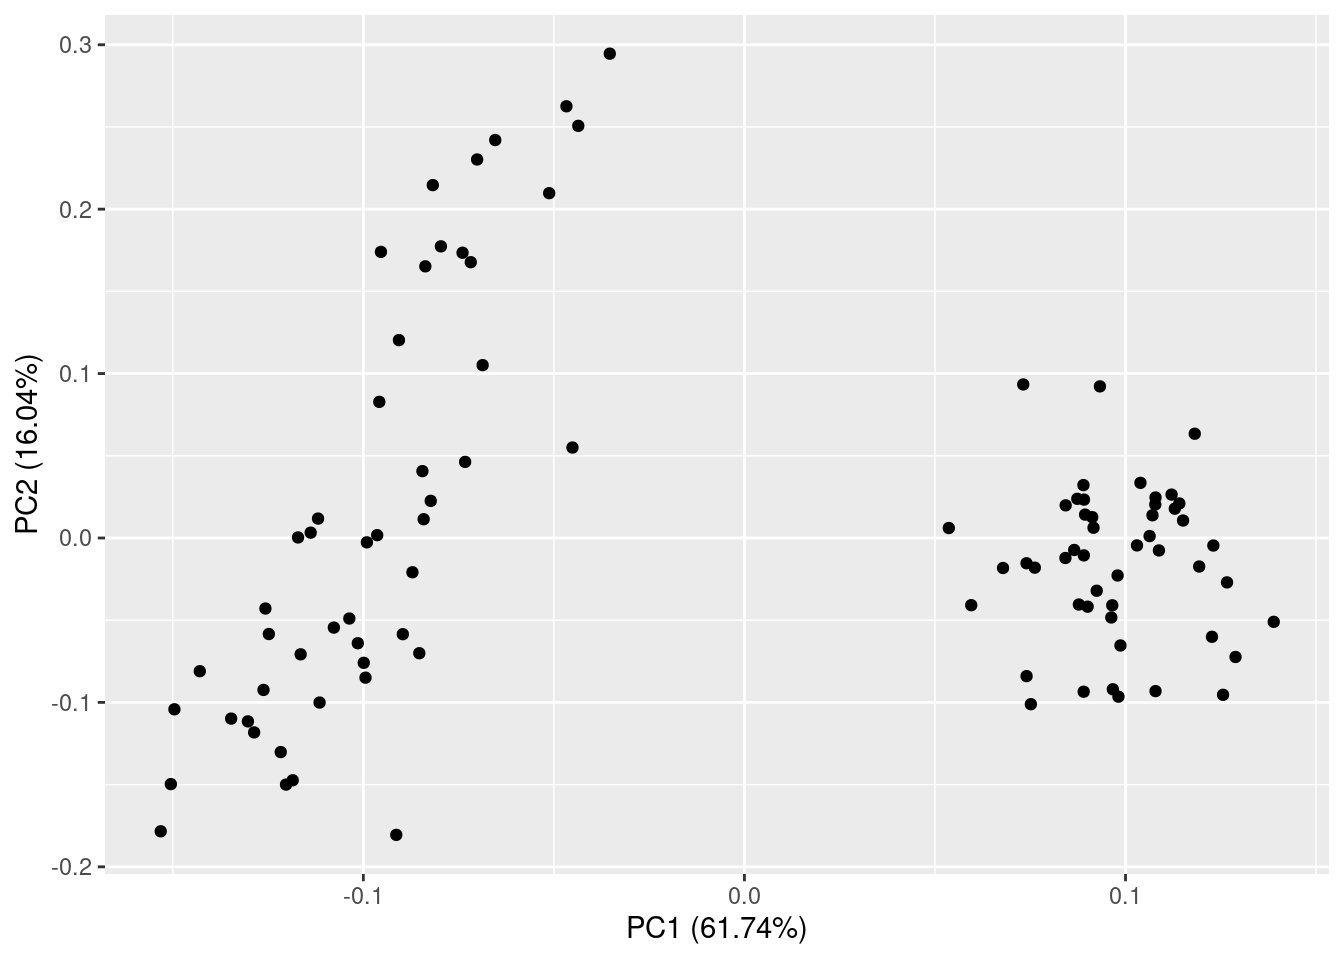

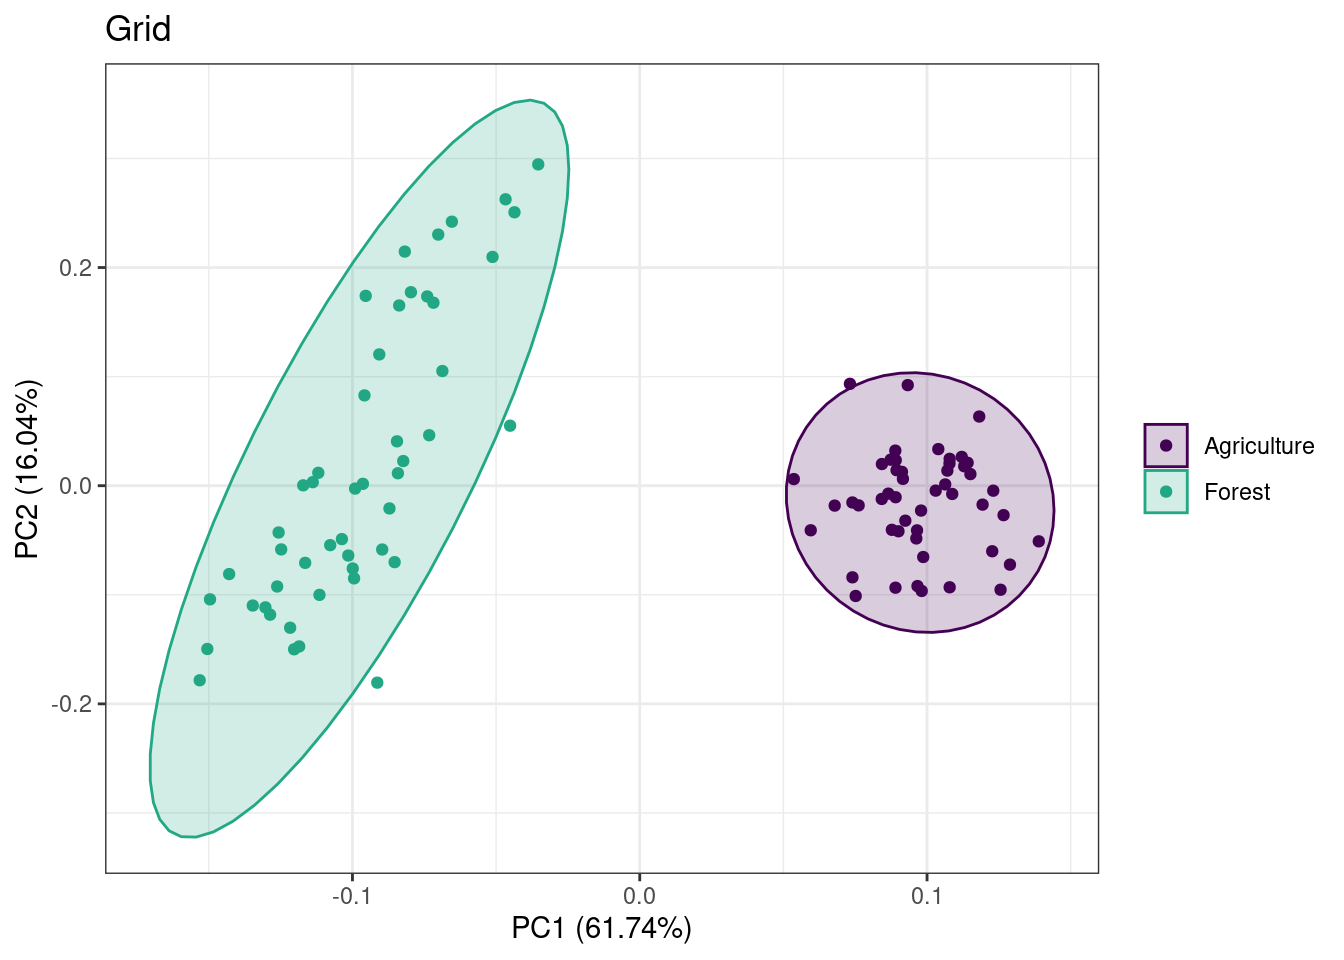

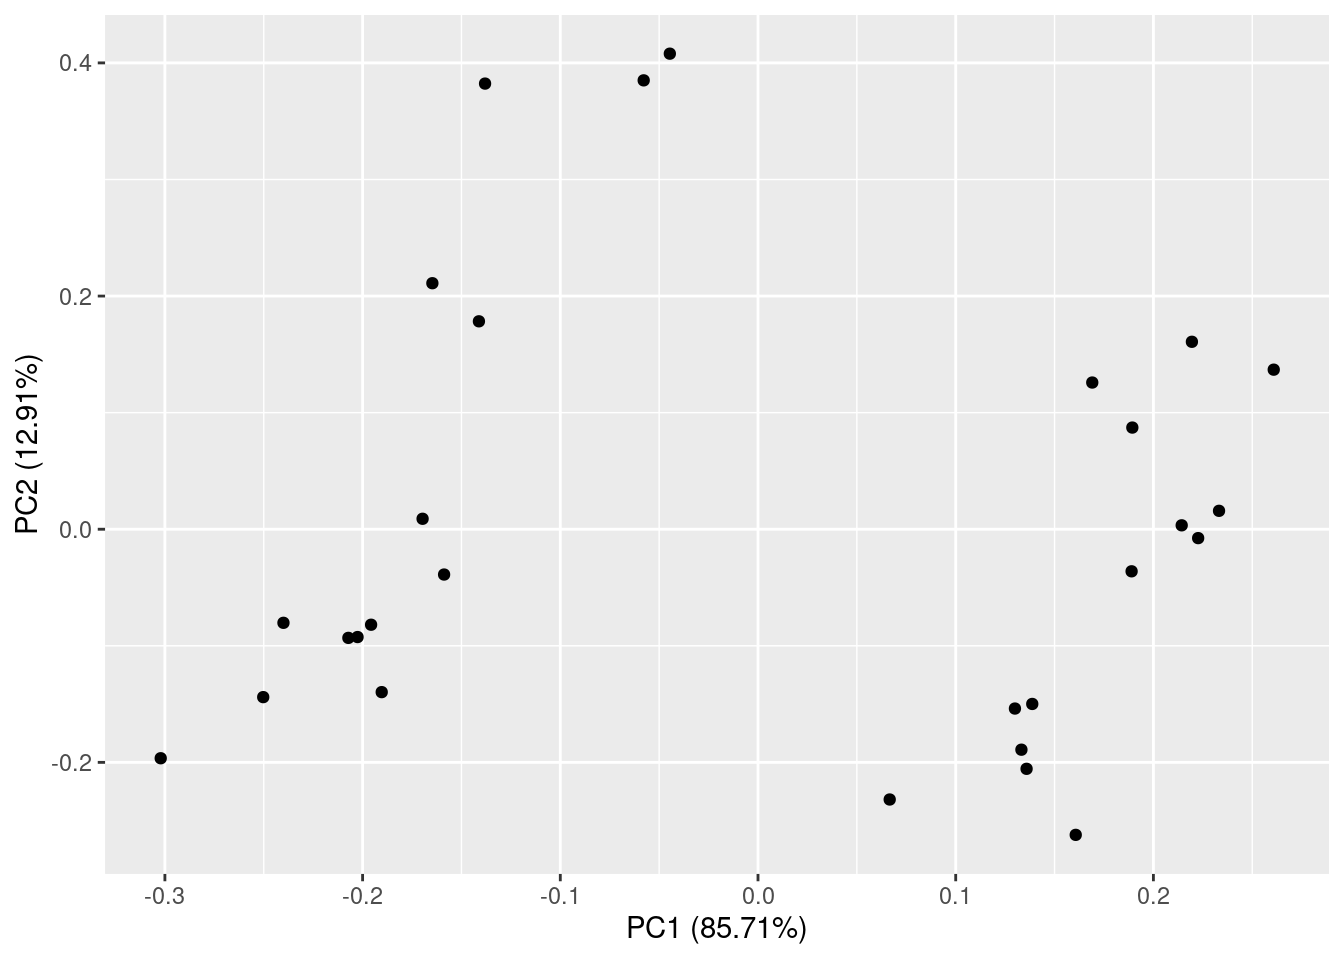

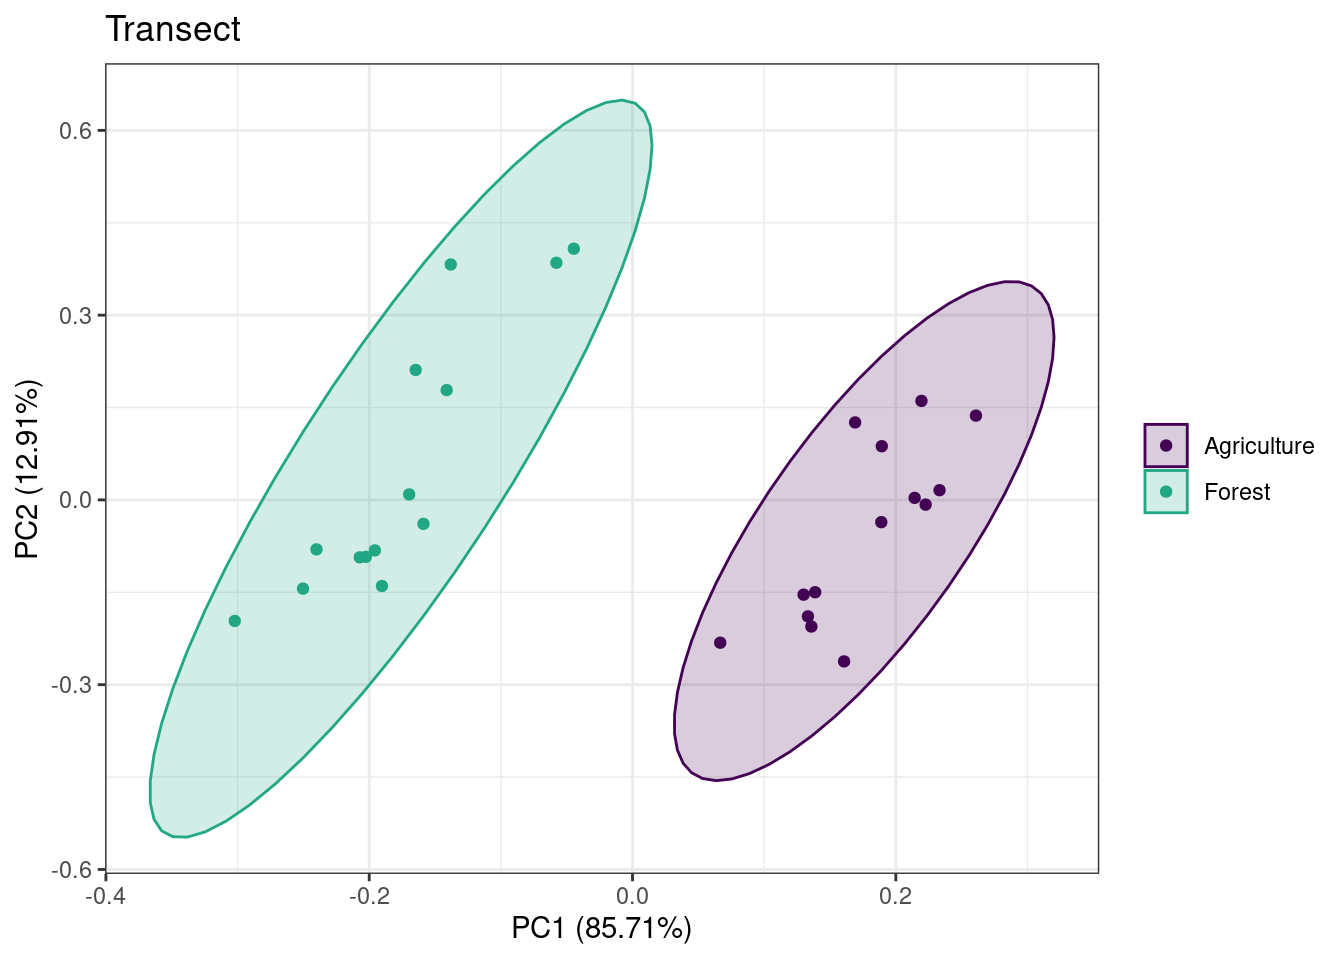

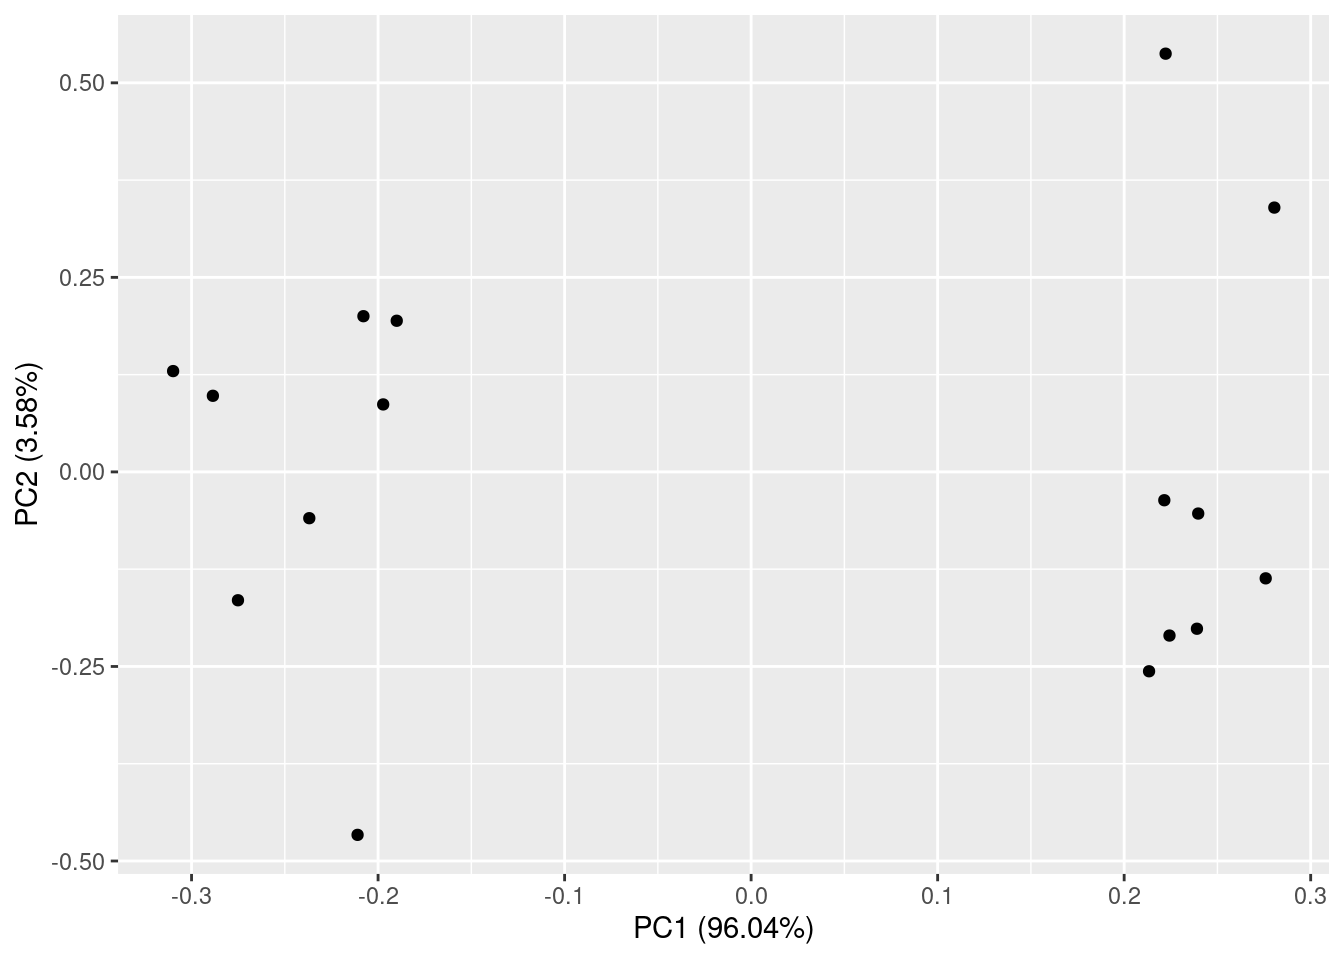

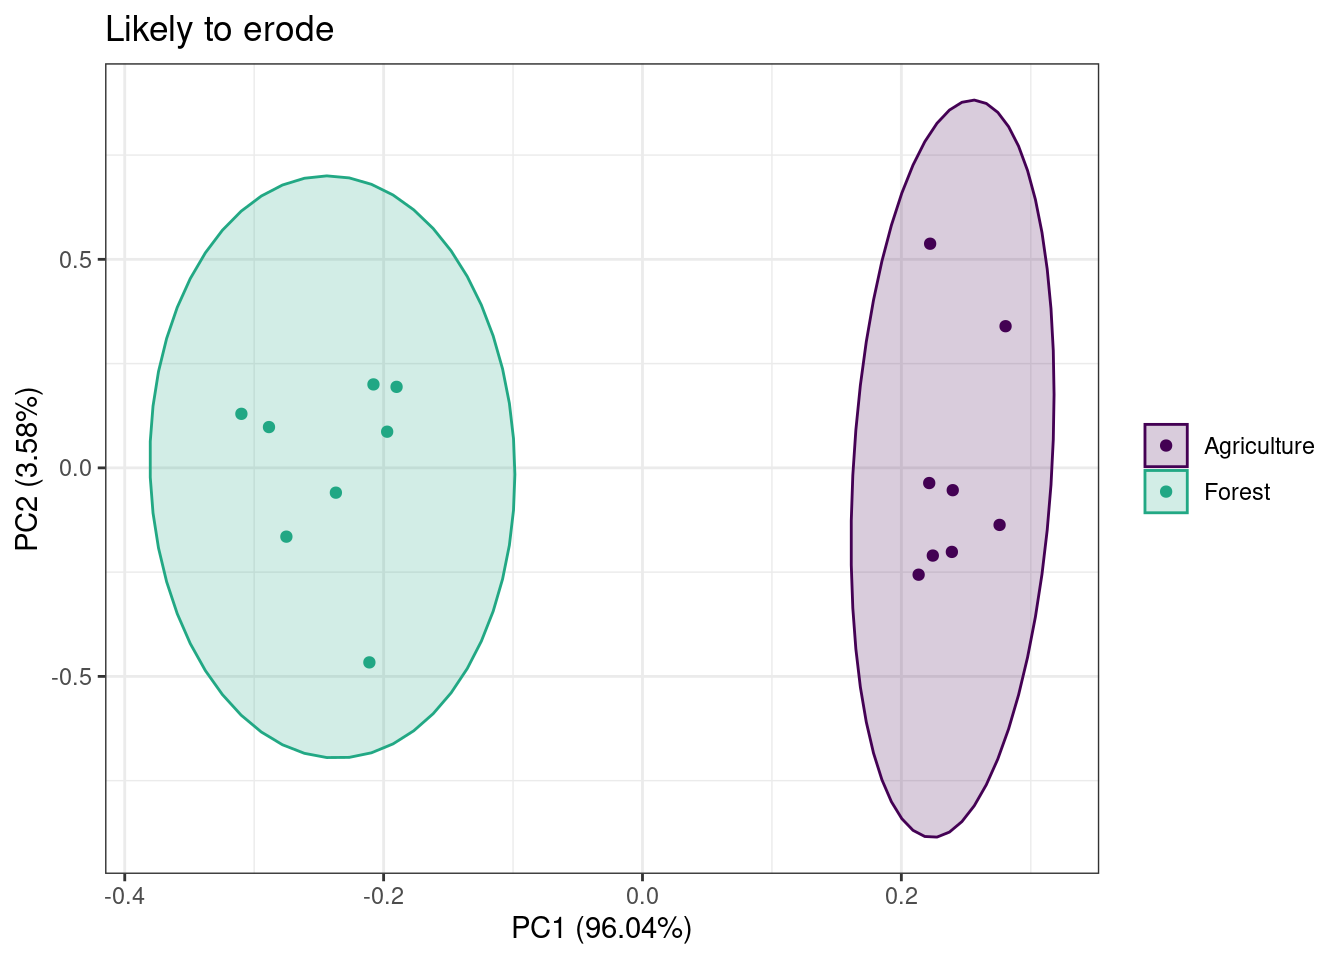

In [ ]:
df_grid <- results %>% 
  filter(sample_design == "Grid") %>%
  filter(Fingerprint %in% grid_dfa) %>%
  pivot_wider(names_from = Fingerprint, values_from = value) %>%
  dplyr::select(-sample_design, -sample_number)

df_transect<- results %>%
  filter(sample_design == "Transect") %>%
  filter(Fingerprint %in% transect_dfa) %>%
  pivot_wider(names_from = Fingerprint, values_from = value) %>%
  dplyr::select(-sample_design, -sample_number)

df_likely <- results %>%
  filter(sample_design == "Likely to erode") %>%
  filter(Fingerprint %in% likely_dfa) %>%
  pivot_wider(names_from = Fingerprint, values_from = value) %>%
  dplyr::select(-sample_design, -sample_number)

pca_grid <- prcomp(select(df_grid, 2:ncol(df_grid)), scale. = TRUE)

autoplot(pca_grid)

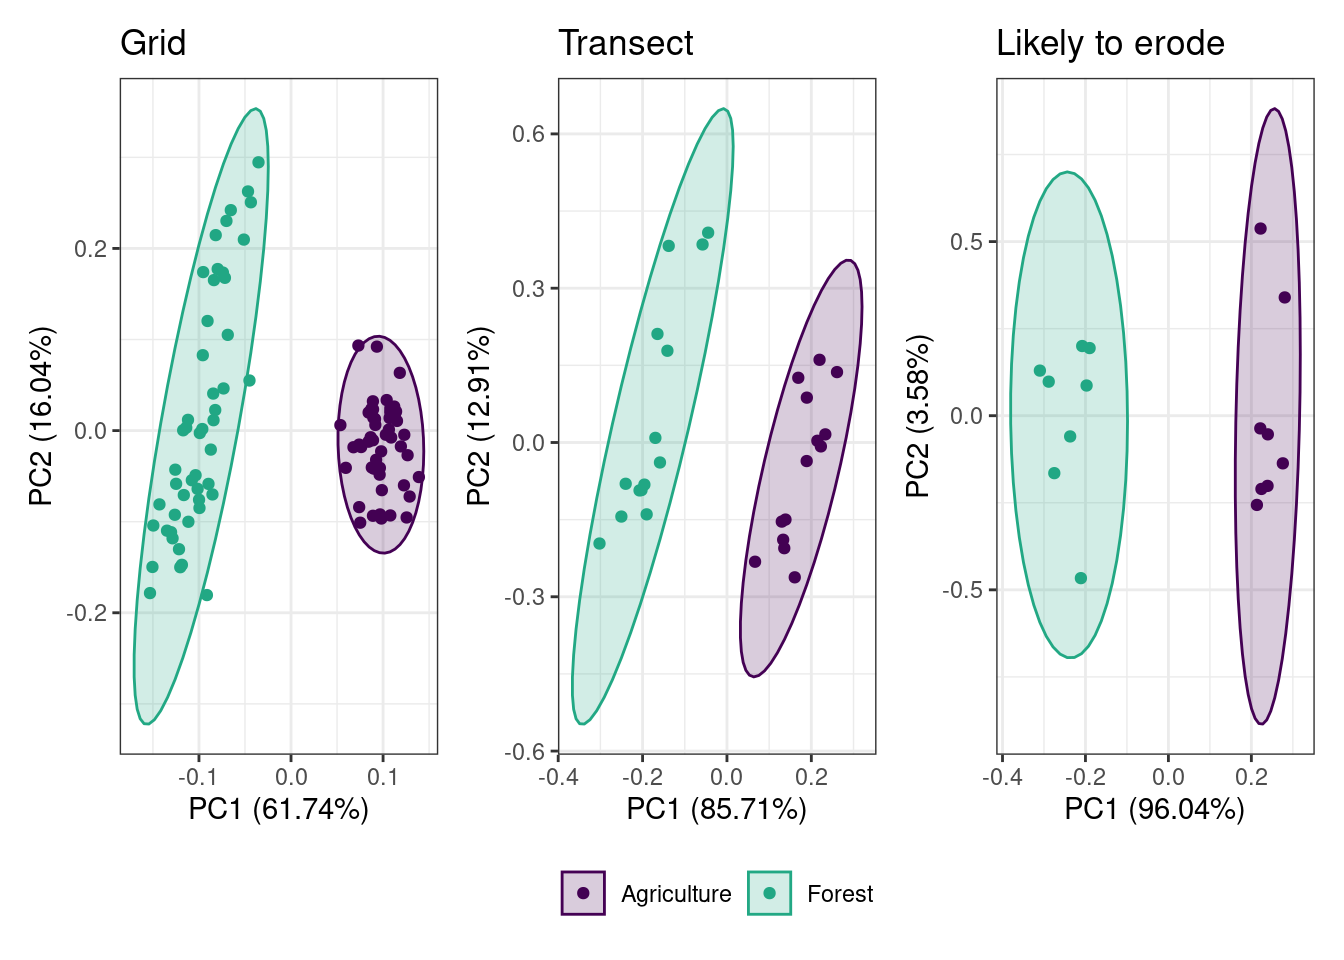

In [ ]:
#| label: fig-pcaplot
#| fig-cap: "Principle component analysis demonstrating the discriminatory ability for the selected fingerprints for the three sampling designs."
p4 <- p1 + p2 + p3 +
  plot_layout(guides = 'collect') & theme(legend.position = "bottom")
p4

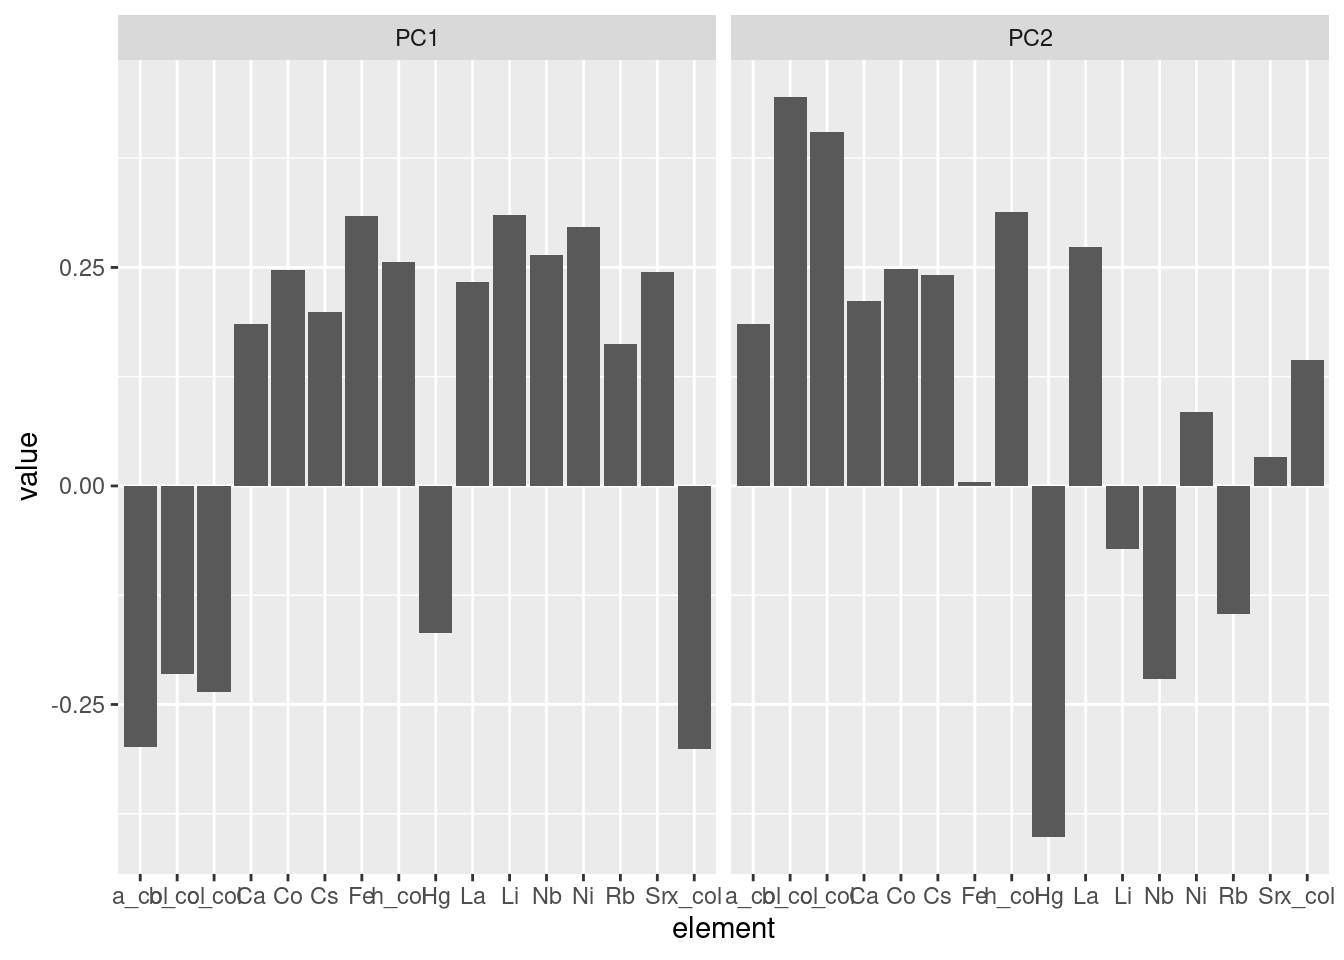

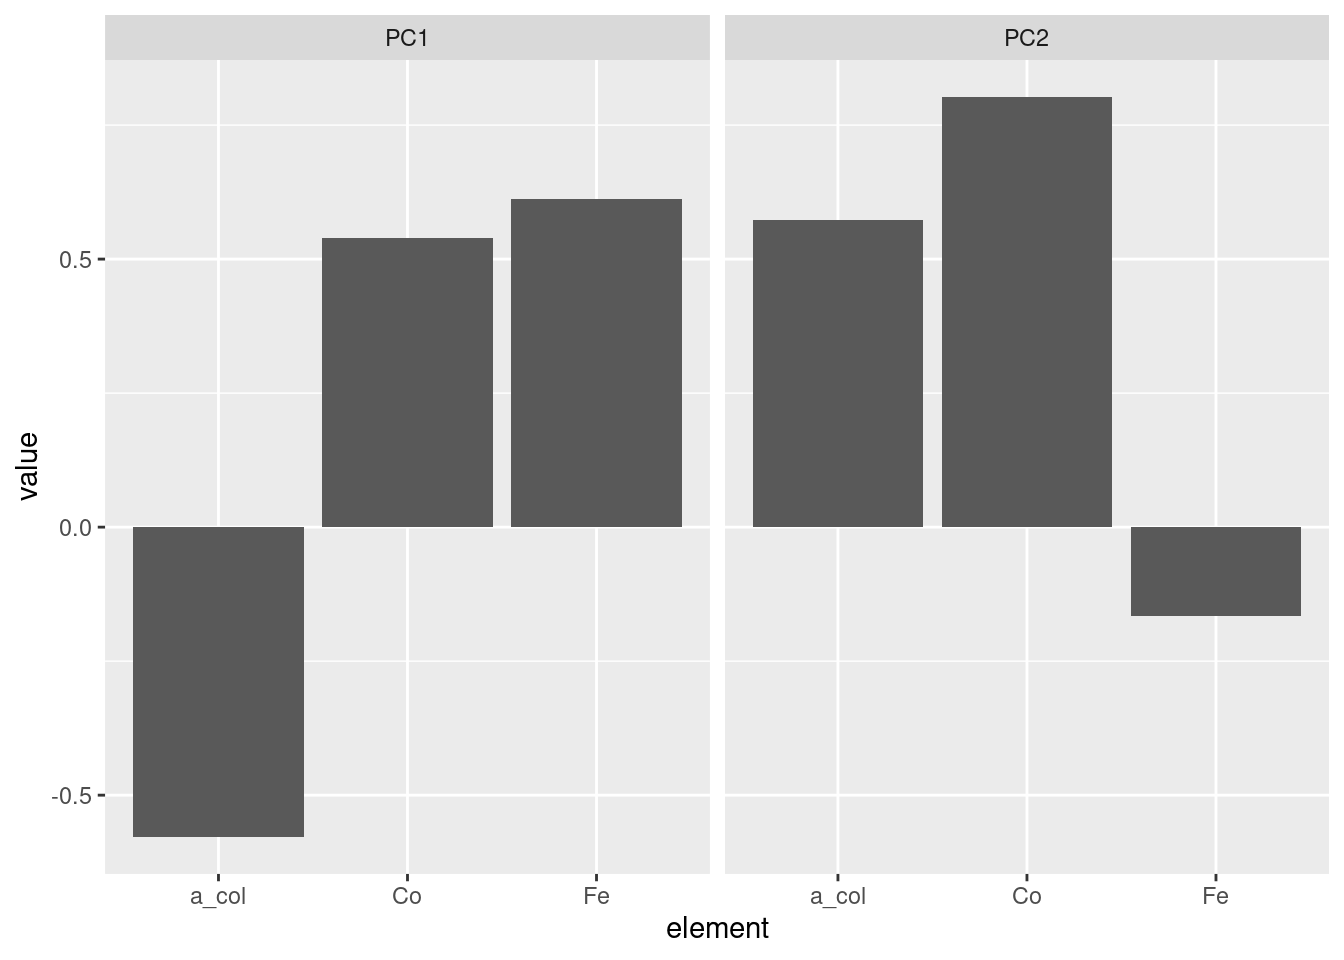

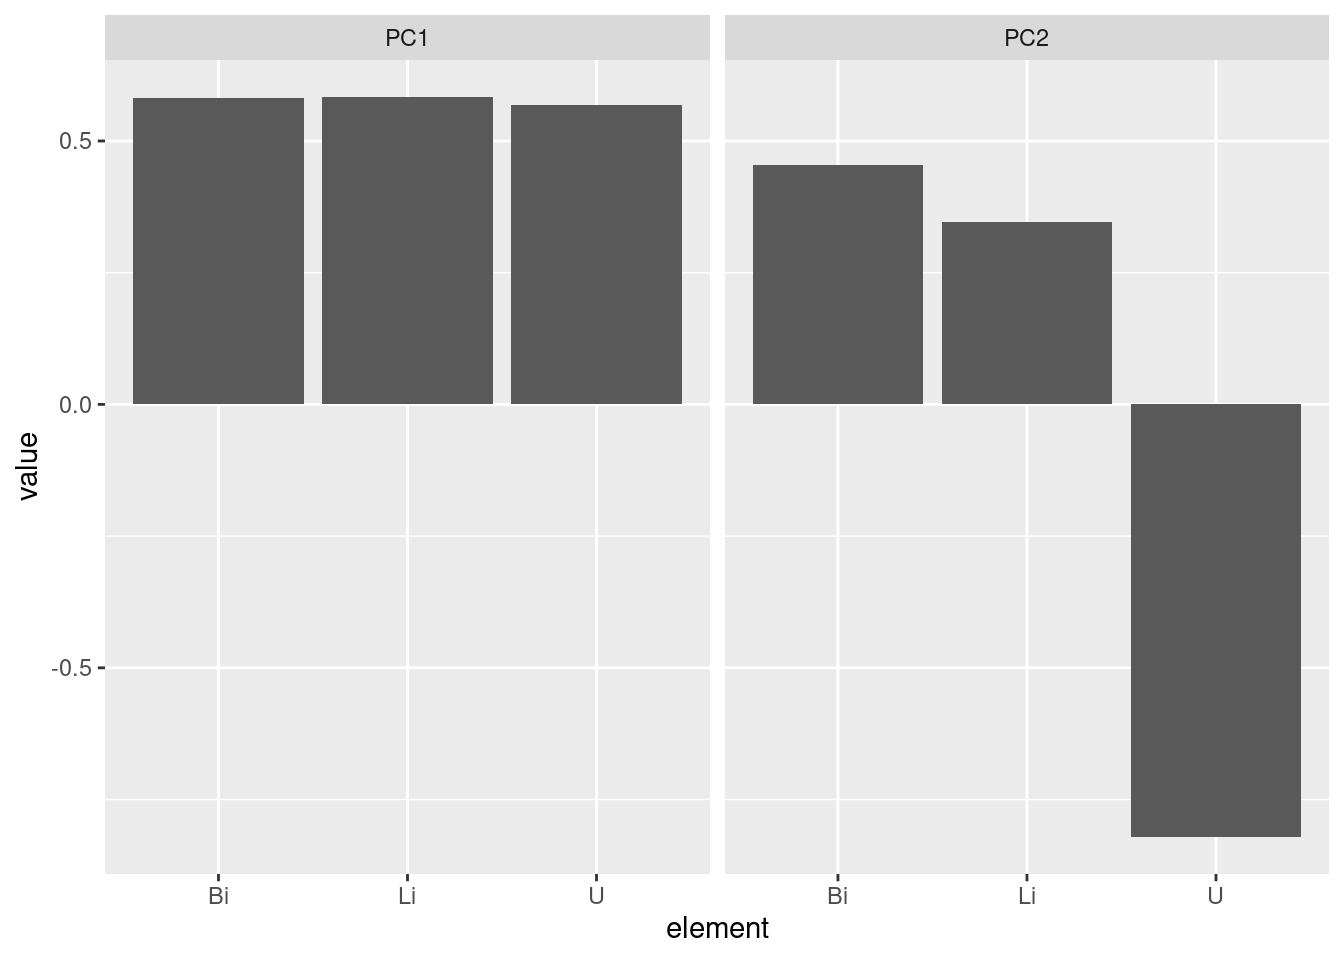

In [ ]:
p5 <- autoplot(pca_grid, 
         data = df_grid, 
         colour = 'site',
         frame = TRUE, 
         frame.type = 'norm',
         loadings = TRUE, loadings.colour = 'blue',
         loadings.label = TRUE, loadings.label.size = 3) +
  theme_bw() +
  scale_colour_viridis_d(begin = 0, end = 0.6) +
  scale_fill_viridis_d(begin = 0, end = 0.6) +
  theme(legend.title = element_blank()) +
  labs(title = "Grid")

grid_loading <- as.data.frame(pca_grid$rotation[,1:2]) %>%
  mutate(element = rownames(.)) %>%
  pivot_longer(cols = c(PC1, PC2), names_to = "PC", values_to = "value")

ggplot(data = grid_loading, aes(x = element, y = value)) +
  geom_col() +
  facet_wrap(~PC)

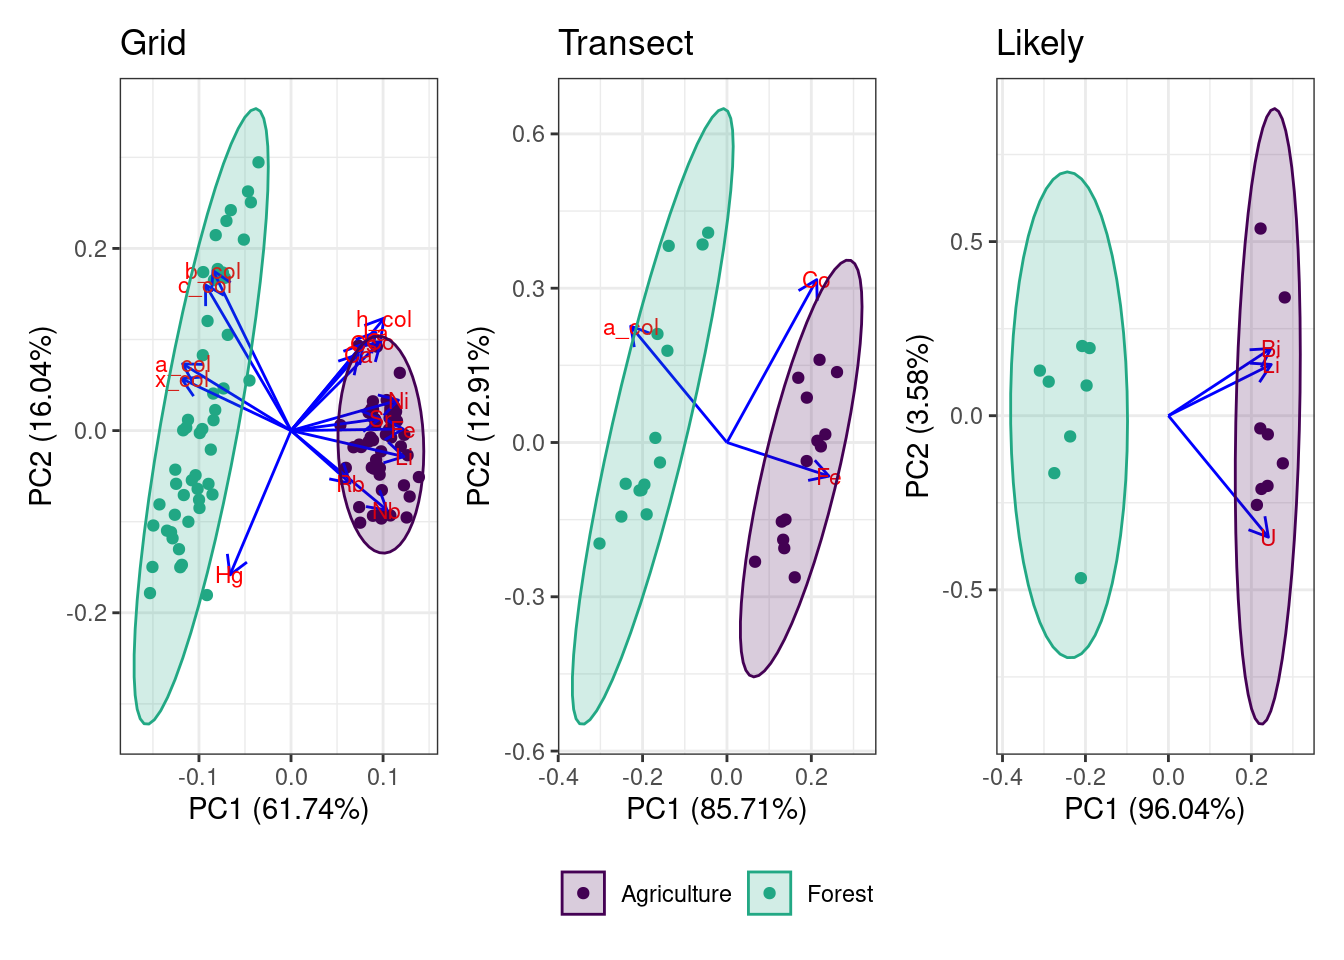

In [ ]:
supfig5 <- p5 + p6 + p7 +
  plot_layout(guides = 'collect') & theme(legend.position = "bottom")
supfig5

## Assess accuracy of discrimination

In [ ]:
grid.lda <- MASS::lda(site ~ ., data = df_grid, na.action = "na.omit", CV = T)
transect.lda <- MASS::lda(site ~ ., data = df_transect, na.action = "na.omit", CV = T)
likely.lda <- MASS::lda(site ~ ., data = df_likely, na.action = "na.omit", CV = T)

### Grid

In [ ]:
table(as.data.frame(df_grid)[,"site"], grid.lda$class)

             
              Agriculture Forest
  Agriculture          49      0
  Forest                0     49

Agriculture      Forest 
          1           1 

### Transect

In [ ]:
table(as.data.frame(df_transect)[,"site"], transect.lda$class)

             
              Agriculture Forest
  Agriculture          14      0
  Forest                0     14

Agriculture      Forest 
          1           1 

### Likely to erode

In [ ]:
table(as.data.frame(df_likely)[,"site"], likely.lda$class)

             
              Agriculture Forest
  Agriculture           8      0
  Forest                0      8

Agriculture      Forest 
          1           1 

### total percent correct

In [ ]:
sum(diag(prop.table(table(as.data.frame(df_grid)[,"site"], grid.lda$class))))

[1] 1

[1] 1

[1] 1

## Percent Classified correctly and Wilks Lamda

### Grid design

In [ ]:
grid_classify <- tibble(n = 1:length(grid_dfa),
            params = map(n, ~grid_dfa[1:.x])) %>%
  mutate(params = map_chr(params, ~paste0(.x, collapse = " + ")),
         f = map(params, ~as.formula(paste0("site ~ ", .x))),
         m = map(f, ~MASS::lda(.x, data = df_grid, na.action = "na.omit", CV = TRUE)),
         c = map_df(m, ~classify(data = df_grid, model = .x))) %>%
  select(-n, -f, -m) %>%
  mutate(wilks = dfa_test$wilks[dfa_test$sample_design == "Grid"][[1]])

grid_classify

# A tibble: 16 × 3
   params                                                  c$Agriculture   wilks
   <chr>                                                           <dbl>   <dbl>
 1 Li                                                                100 0.0620 
 2 Li + a_col                                                        100 0.0441 
 3 Li + a_col + Fe                                                   100 0.0276 
 4 Li + a_col + Fe + Co                                              100 0.0233 
 5 Li + a_col + Fe + Co + Hg                                         100 0.0217 
 6 Li + a_col + Fe + Co + Hg + x_col                                 100 0.0188 
 7 Li + a_col + Fe + Co + Hg + x_col + Cs                            100 0.0178 
 8 Li + a_col + Fe + Co + Hg + x_col + Cs + La                       100 0.0145 
 9 Li + a_col + Fe + Co + Hg + x_col + Cs + La + Ni                  100 0.0134 
10 Li + a_col + Fe + Co + Hg + x_col + Cs + La + Ni + Nb             100 0.0128 
11 Li + a

### Transect design

In [ ]:
transect_classify <- tibble(n = 1:length(transect_dfa),
                        params = map(n, ~transect_dfa[1:.x])) %>%
  mutate(params = map_chr(params, ~paste0(.x, collapse = " + ")),
         f = map(params, ~as.formula(paste0("site ~ ", .x))),
         m = map(f, ~MASS::lda(.x, data = df_transect, na.action = "na.omit", CV = TRUE)),
         c = map_df(m, ~classify(data = df_transect, model = .x))) %>%
  select(-n, -f, -m) %>%
  mutate(wilks = dfa_test$wilks[dfa_test$sample_design == "Transect"][[1]])

transect_classify

# A tibble: 3 × 3
  params          c$Agriculture $Forest  wilks
  <chr>                   <dbl>   <dbl>  <dbl>
1 Fe                        100     100 0.0515
2 Fe + a_col                100     100 0.0252
3 Fe + a_col + Co           100     100 0.0185

### Likely to erode design

In [ ]:
likely_classify <- tibble(n = 1:length(likely_dfa),
                            params = map(n, ~likely_dfa[1:.x])) %>%
  mutate(params = map_chr(params, ~paste0(.x, collapse = " + ")),
         f = map(params, ~as.formula(paste0("site ~ ", .x))),
         m = map(f, ~MASS::lda(.x, data = df_likely, na.action = "na.omit", CV = TRUE)),
         c = map_df(m, ~classify(data = df_likely, model = .x))) %>%
  select(-n, -f, -m) %>%
  mutate(wilks = dfa_test$wilks[dfa_test$sample_design == "Likely to erode"][[1]])

likely_classify

# A tibble: 3 × 3
  params      c$Agriculture $Forest   wilks
  <chr>               <dbl>   <dbl>   <dbl>
1 Li                    100     100 0.0237 
2 Li + U                100     100 0.0112 
3 Li + U + Bi           100     100 0.00762

## Mean and SD plotting

In [ ]:
plotting3 <- results %>%
  filter(Fingerprint %in% unique(c(grid_dfa, likely_dfa, transect_dfa))) %>%
  group_by(Fingerprint, sample_design, site) %>%
  summarise(avg = mean(value),
            sd = sd(value), 
            se = sd(value)/(n()^0.5)) %>%
  rename("Source" = site) %>%
  mutate(Fingerprint = as.factor(Fingerprint)) %>%
  mutate(Fingerprint = fct_recode(Fingerprint, "italic(`a*`)" = "a_col", "italic(`b*`)" = "b_col", "italic(`c*`)" = "c_col", "italic(`h*`)" = "h_col", "italic(`x*`)" = "x_col", "`Ca (%)`" = "Ca"))

`summarise()` has grouped output by 'Fingerprint', 'sample_design'. You can
override using the `.groups` argument.

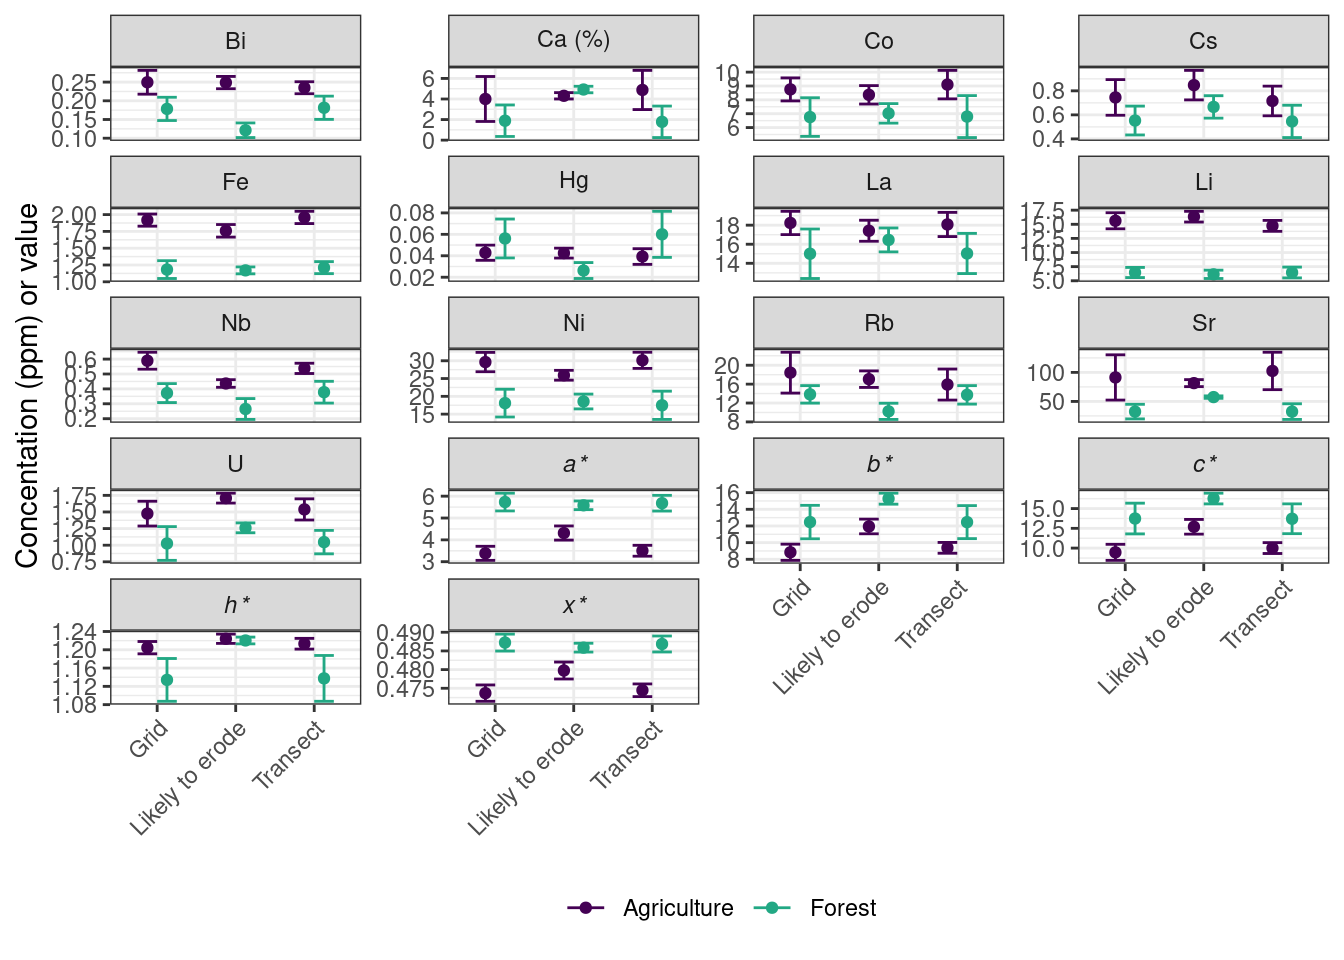

In [ ]:
#| label: fig-sdplot-test
#| fig-cap: "Means and standard deviations of the fingerprints used in the mixing model."
p1 <- ggplot(data = plotting3, aes(x = sample_design, y = avg, colour = Source)) +
  geom_point(position = position_dodge(width = 0.5)) +
  geom_errorbar(data = plotting3, aes(ymax = avg + sd, ymin = avg -sd, x = sample_design), position = position_dodge(width = 0.5), width = 0.5) +
  scale_colour_viridis_d(begin = 0, end = 0.6) +
  theme_bw() +
  labs(y = "Concentation (ppm) or value") +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
        legend.position = "bottom",
        legend.title = element_blank()) +
  facet_wrap(~Fingerprint, ncol = 4, scales = "free_y", labeller = "label_parsed")

p1